In [1]:
import re
import warnings
import pandas as pd
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.corpus import stopwords
from transformers import AutoTokenizer, AutoModel, pipeline
# from spellchecker import SpellChecker

warnings.filterwarnings('ignore')

2024-05-18 11:39:52.892658: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 11:39:52.892781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 11:39:53.016830: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
categories = ["Electronics", "Camera", "Mobile_Electronics", "PC", "Software", "Wireless"]

category_datasets = []
for category in tqdm(categories):
    kaggle_dataset_path = f"/kaggle/input/amazon-us-customer-reviews-dataset/amazon_reviews_us_{category}_v1_00.tsv"

    category_dataset = pd.read_csv(kaggle_dataset_path, sep='\t', quoting=3)
    category_datasets.append(category_dataset)
    print(f"Loaded dataset for {category}")
    
dataset = pd.concat(category_datasets)
dataset.head()

 17%|█▋        | 1/6 [00:45<03:48, 45.63s/it]

Loaded dataset for Electronics


 33%|███▎      | 2/6 [01:13<02:20, 35.14s/it]

Loaded dataset for Camera


 50%|█████     | 3/6 [01:14<00:59, 19.74s/it]

Loaded dataset for Mobile_Electronics


 67%|██████▋   | 4/6 [02:51<01:40, 50.06s/it]

Loaded dataset for PC


 83%|████████▎ | 5/6 [02:57<00:34, 34.14s/it]

Loaded dataset for Software


100%|██████████| 6/6 [04:54<00:00, 49.04s/it]

Loaded dataset for Wireless


,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


## Clean data
- clear reviews with insufficient total_votes
- clear HTML tags from text
- fix typos
- remove links or hyperlinks from reviews

In [3]:
dataset = dataset.dropna()
dataset = dataset[dataset.verified_purchase == 'Y']

In [4]:
dataset.review_id.nunique(), len(dataset)

(18355671, 18355671)

In [5]:
def remove_html_tags_and_links(text):
    # Remove HTML tags
    cleaned_text = re.sub(r'<[^>]+>', '', text)
    
    # Remove hyperlinks
    cleaned_text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', cleaned_text)
    
    return cleaned_text

In [6]:
dataset["review"] = dataset["review_headline"] + "\n" + dataset["review_body"]

### Take only the reviews which recieved at least 10 votes

In [7]:
dataset = dataset[dataset.total_votes >= 10]
dataset["usefulness"] = dataset["helpful_votes"] / dataset["total_votes"]
dataset = dataset[["review_id", "product_category", "total_votes", "review", "usefulness"]]

In [8]:
dataset.head()

,review_id,product_category,total_votes,review,usefulness
41,R1FBO737KD9F2N,Electronics,23,Great noise cancelling headphones for the pric...,0.826087
145,R227GSNWI6BSZV,Electronics,20,"Garbage, lasted 8 months... warranty is useles...",1.000000
265,R4PF7S0TOV9S7,Electronics,17,A long lasting bluetooth sound bazooka!\nThis ...,0.882353
274,R22LKIOKMSOG8A,Electronics,13,nice!\nThis is a nice little turntable. Don't ...,0.923077
304,R3SJTYZBYBG4EE,Electronics,99,Very good charger for the price! But has a dow...,1.000000


In [9]:
dataset["review"] = dataset["review"].apply(remove_html_tags_and_links)

Text(0.5, 1.0, 'Log-occurence of sentence length in tokens')

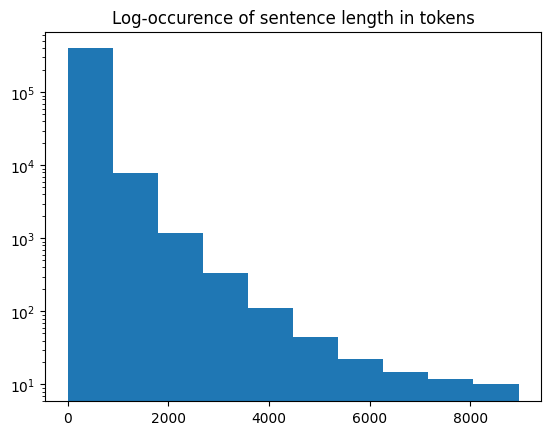

In [10]:
plt.hist(dataset["review"].apply(lambda x: len(x.split())), log=True);
plt.title("Log-occurence of sentence length in tokens")

In [11]:
# Remove excessively large reviews
dataset = dataset[dataset["review"].apply(lambda x: len(x.split())) <= 2000]

Text(0.5, 1.0, 'Log-occurence of sentence length in tokens after thresholding')

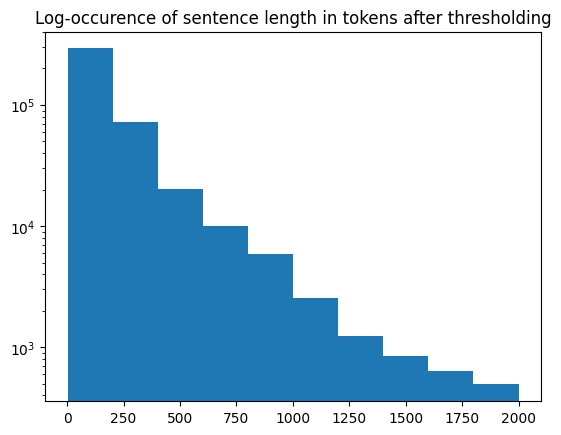

In [12]:
plt.hist(dataset["review"].apply(lambda x: len(x.split())), log=True);
plt.title("Log-occurence of sentence length in tokens after thresholding")

## Augment textual data with translation

In [13]:
cycles = [
    [pipeline("translation", model="Helsinki-NLP/opus-mt-en-ru"), pipeline("translation", model="Helsinki-NLP/opus-mt-ru-en")],
    [pipeline("translation", model="Helsinki-NLP/opus-mt-en-fr"), pipeline("translation", model="Helsinki-NLP/opus-mt-fr-en")],
]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

In [14]:
def augment_sentence(sent):
    if np.random.random() > 0.001:
        return sent
    cycle = cycles[np.random.randint(len(cycles))]
    try:
        for comp in cycle:
          sent = comp(sent)[0]['translation_text']
        return sent
    except:
        return sent

In [15]:
tqdm.pandas(desc='Augmenting texts')

In [16]:
# dataset["review"] = dataset["review"].progress_apply(augment_sentence)

## Save the data

In [17]:
dataset.to_parquet("preprocessed_data.parquet")

In [18]:
!zip data.zip preprocessed_data.parquet

  adding: preprocessed_data.parquet (deflated 13%)


In [19]:
!rm preprocessed_data.parquet

In [20]:
from IPython.display import FileLink
FileLink(r'data.zip')

/kaggle/working/data.zip